In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
%matplotlib widget
from matplotlib import rcParams

# Plotting format for thesis
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

In [ ]:
"""
A collection of functions to perform a dark photon search on an averaged spectrum


Functions
-------
median_filt(
    
):
    LPF for spectrum. Recomended as a pre-filter if
    spec contains large, very narrow candidates

butter_filt(

):
    LPF for spectrum. 

SG_filt(

):
    LPF for spectrum

match_filt(
    
):
    Performs a matched filtering on approx. normally distributed data
    Internal helper functions include freq2idx and genNuSteps

set_limit(

):
    Sets a limit (or series of limits) on an array of 
    normally distributed data (or list of arrays of normal data)

get_required_sigma(

):
    Given a number of samples and a desired confidence limit, tells you how 
    many "N" sigma you need to go to in order to be CL% confident no samples
    are above the calculated "N" 
"""
import numpy as np 
import scipy.signal as spsig
import scipy.ndimage as spim
import cupyx.scipy.ndimage as cpim
import cupy as cp
from scipy.signal import butter, filtfilt
import scipy.stats
import scipy.special
from scipy.optimize import fsolve

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]



def median_filt(spec, filter_size=51):
    """
    Function to apply median filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    filter_size : int, optional
        Size of the median filter. Default is 50.

    Returns
    -------
    spectrum_filtered : array
        The median-filtered spectrum.
    """
    spectrum_gpu = cp.array(spec)
    spectrum_filtered_gpu = cpim.median_filter(
        spectrum_gpu,
        size=(filter_size),
        origin=0
    )
    spectrum_filtered = spectrum_filtered_gpu.get()
    return spectrum_filtered

def butter_filt(spec, cutoff=40000, order=6):
    """
    Function to apply Butterworth low-pass filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    cutoff : int, optional
        Cutoff frequency for the filter. Default is 40000.

    order : int, optional
        Order of the filter. Default is 6.

    Returns
    -------
    spectrum_filtered : array
        The Butterworth low-pass filtered spectrum.
    """
    nyq = 0.5 * len(spec)  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    spectrum_filtered = filtfilt(b, a, spec)
    return spectrum_filtered

def sg_filt(spec, window_length=51, polyorder=4):
    """
    Apply a Savitzky-Golay filter to the spectrum.

    Parameters
    ----------
    window_length : int, optional
        Length of the filter window; must be a positive odd integer, default is 51.
    polyorder : int, optional
        Order of the polynomial used to fit the samples, default is 1.

    Returns
    -------
    arr
        Filtered spectrum.
    """
    spectrum_filtered = spsig.savgol_filter(spec, window_length=window_length, polyorder=polyorder)
    return spectrum_filtered

def matched_filt(freqs, 
    spec, 
    startFreq, 
    stopFreq, 
    percent, 
    overlap
    ):
    """
    Apply a matched filter to the input spectrum over a specified frequency range.

    This function divides the freqs range into steps and applies a convolution
    operation with a lambda template for each step. The function returns the 
    convolved output for each freqs segment.

    Parameters
    ----------
    freqs : array-like
        Array of frequencies corresponding to the input spectrum.
    spec : array-like
        Array of spectral values to be filtered.
    startFreq : float
        Starting freqs of the range over which the filter is applied.
    stopFreq : float
        Stopping frequency of the range over which the filter is applied.
    percent : float
        Percentage to determine the step size between successive frequencies in the
        range (startFreq to stopFreq).
    overlap : int
        Number of overlapping elements between successive frequency segments.

    Returns
    -------
    tuple
        A tuple containing two lists:
        - outputFreqs: List of arrays with the frequencies corresponding to each segment.
        - outputConv: List of arrays with the convolved values for each segment.

    Notes
    -----
    Frequency step generation (`gen_nu_steps`) is
    defined internally within this function.
    """
    def gen_nu_steps(freqs, startFreq, stopFreq, percent):
        freq    = startFreq
        nuStepList  = []
        while freq < stopFreq:
            #if freq > freqs:
            #    nu0Arr.append(400)
            nuStepList.append(freq)
            endFreq = freq + freq*percent/100
            freq = endFreq
        nuStepList.append(stopFreq) 
        #print(nuStepList)
        return nuStepList
            
    nuStepList  = gen_nu_steps(freqs, startFreq, stopFreq, percent)
    outputConv  = []
    outputFreqs = []
    #change template over frequency range
    for i, nu in enumerate(nuStepList[0:-1]):
        idxStart        = freq2idx(nuStepList[i], freqs) - overlap
        nu0             = nuStepList[i] + (nuStepList[i+1] - nuStepList[i])/2
        if 0: #nuStepList[i+1] == stopFreq:
            idxStop     = freq2idx(nuStepList[i+1], freqs) - 10
        else:
            idxStop     = freq2idx(nuStepList[i+1], freqs) + overlap
        lamOut      = lam(freqs, nu0, p0=1, nBins=100)
        subConv     = np.convolve(np.flip(lamOut[1]), spec[idxStart:idxStop], mode='same')[overlap:-overlap]
        subFreqs    = freqs[idxStart+overlap:idxStop-overlap]
        
        outputConv.append(subConv)
        outputFreqs.append(subFreqs)
    return (outputFreqs, outputConv)

def lam(nu, nu0, p0 = None, nBins=None, v0=220, vlab=233, offset = 0):
    """
    Lambda function for matched filtering.
    Work in MHz, this will explode for large frequency values (ie 100e6 Hz)
    velocity args in km/s
    vlab has yearly modulation between about 220 and 255, see fig 3a in Gramolin
    output is normilized to p0 if given

    Parameters
    ----------
    nu : float
        Frequency.
    nu0 : float
        Center frequency.
    p0 : float, optional
        Power normalization value, default is None.
    nBins : int, optional
        Number of bins, default is None.
    v0 : int, optional
        Velocity parameter, default is 220.
    vlab : int, optional
        Lab velocity parameter, default is 233.
    offset : int, optional
        Frequency offset, default is 0.

    Returns
    -------
    tuple
        Frequencies and output power spectral density.
    """
    if nBins is not None:
        # find the index of nu0 in nu array
        idx = np.abs(nu-nu0).argmin()

        # calculate the slice start and end indices
        start_idx = max(0, idx - nBins//2)
        end_idx = min(len(nu), idx + nBins//2)
        nu = nu[start_idx:end_idx]

    c       = 299792 #km/s
    nu0     = nu0 + offset
    beta    = np.zeros_like(nu) # initialise beta with zeros

    mask    = (nu > nu0) # create a mask of values where nu > nu0
    # calculate beta only for values where nu > nu0
    beta[mask] = (2*c*vlab)/(v0**2) * np.sqrt((2*(nu[mask]-nu0))/(nu0))
    beta    = np.minimum(beta, 100)
    a       = (2*c**2)/(np.sqrt(np.pi)*v0*vlab*nu0)
    b       = -((beta**2*v0**2)/(4*vlab**2)) - (vlab**2/v0**2) 

    lamArr  = a*np.exp(b)*np.sinh(beta)
    if p0 is not None:
        outPSD = p0/np.sum(lamArr) * lamArr #normilize to p0
    else:
        outPSD = lamArr

    return nu, outPSD 

def get_required_sigma(nBins, desired_confidence):    
    """
    Calculate the required standard deviation (sigma) level to achieve a specified
    confidence level that none of the samples in a given number of bins will exceed
    that sigma level.

    The function solves for the sigma level using the cumulative distribution function
    of the normal distribution and the binomial probability for the given number of bins.

    Parameters
    ----------
    nBins : int
        The number of bins or samples drawn from a normal distribution.
    desired_confidence : float
        The desired confidence level (between 0 and 1) for the probability that none
        of the samples will exceed the calculated sigma level. eg 0.95

    Returns
    -------
    float
        The calculated sigma level required to achieve the desired confidence.

    Notes
    -----
    The function uses the `fsolve` method from SciPy's optimize module to solve for
    the sigma value. If the solver does not converge, it returns a guessed value
    based on the inverse error function.
    """

    desired_confidence = 1-desired_confidence
    def probability_greater_than(sigma):
        return 0.5-scipy.special.erf(sigma/np.sqrt(2))/2

    def binomial(N, num_successes, prob_of_success):
        return scipy.special.comb(N, num_successes)*prob_of_success**(num_successes)*(1-prob_of_success)**(N-num_successes)

    def probability_none_above(nBins, sigma):
        # returns probability that after nBins of draws from a normal distribution
        # that none of the draws will be above the sigma upper limit (mean+sigma)
        return 1-binomial(nBins, nBins, 1-probability_greater_than(sigma))

    guess     = scipy.special.erfinv(1-(2*(desired_confidence)/nBins))*np.sqrt(2) #from taylor expantion
    nSig, solDict, itr, msg   = fsolve(lambda sigma: probability_none_above(nBins, sigma)-desired_confidence, guess, full_output=True)
    nSig = nSig[0]
    if itr != 1:
        print('fSolve in get_required_sigma failed. Using guess')
        print(msg)
        nSig = guess
    
    return nSig

def set_lim(freqs, spec, CL):
    """
    Calculate the frequency limits and standard deviations for the given spectra.

    This function computes the limits by applying the required sigma to each segment
    of the input spectra and then concatenates the results to form the complete limit.
    It also flattens and concatenates the input frequency and spectrum arrays to match
    the shape of the limit.

    Parameters
    ----------
    freqs : arr or list of arr
        Array(s) of frequencies corresponding to the input spectra. If a single array
        is provided, it is wrapped in a list to form an array of arrays.
    spec : arr or list of arr
        Array(s) of spectra to calculate the limits for. If a single array is provided,
        it is wrapped in a list to form an array of arrays.
    CL : float
        Confidence level for calculating the required sigma. This value is used to
        determine how many standard deviations to apply to the spectra.

    Returns
    -------
    tuple
        A tuple containing three arrays: the concatenated frequency array, the
        concatenated spectrum array, and the calculated limit array.
    """
    # If the inputs are 1-D arrays, wrap them in a list to make them an array of arrays
    if isinstance(spec, (np.ndarray, list)) and not isinstance(spec[0], (np.ndarray, list)):
        freqs   = [freqs]
        spec    = [spec]
    nSamps = len(np.hstack(freqs))
    nSig = get_required_sigma(nSamps, CL)

    limits = []
    for idx in range(len(spec)):
        limits.append(nSig * 1.4826 * scipy.stats.median_abs_deviation(spec[idx]))

    limit   = np.concatenate([np.repeat(limit, len(freqs)) for limit, freqs in zip(limits, freqs)])
    freqs   = np.hstack(freqs)
    spec    = np.hstack(spec)

    return (freqs, spec, limit)

def freq2idx(freq, freqs):
    return int(freq/freqs[-1]*len(freqs))


60
0.0001076092061767188


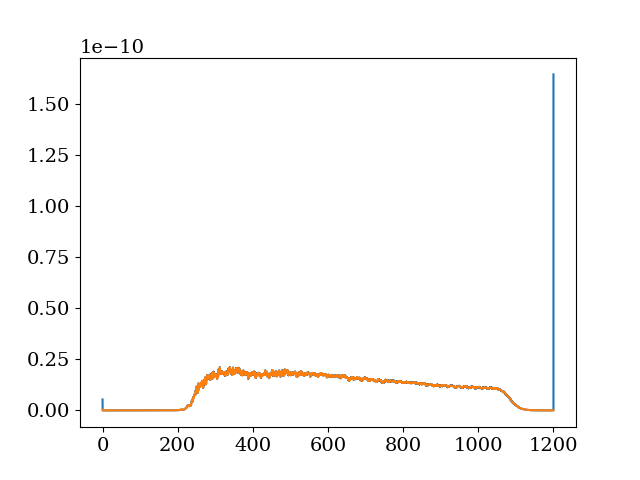

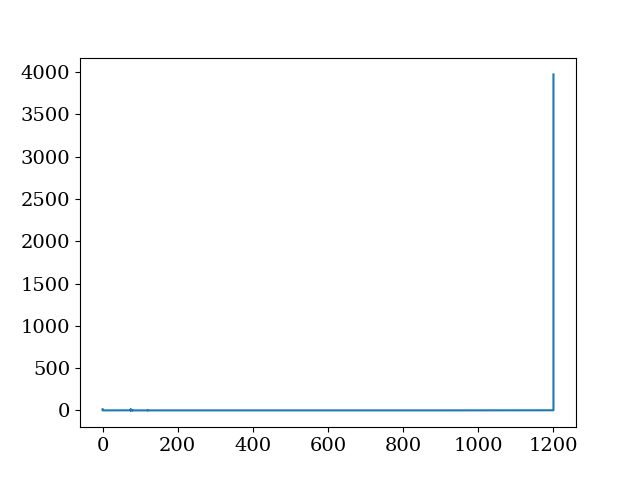

In [ ]:
spec    = np.load('./avgSpecs_gitignore/avgAntSpec_W_ALL_103M_FFTs_11_5_24.npy', allow_pickle=True)
avgTermSpec         = np.load('./avgSpecs_gitignore/avgTermSpec_W_ALL_103M_FFTs_11_5_24.npy' , allow_pickle=True)
avgVetoSpec         = np.load('./avgSpecs_gitignore/avgVetoSpec_W_ALL_103M_FFTs_11_5_24.npy', allow_pickle=True)
freqs       = np.linspace(0, 2400/2, 2**22, dtype=np.float64)

medFilt = median_filt(spec, 
    filter_size=51)

H       = butter_filt(medFilt,
    cutoff=40000,
    order = 6)

normSpec = spec / H

matchedOut      = matched_filt(freqs, 
    normSpec,
    startFreq   = 295,
    stopFreq    = 1005,
    percent     = 10,
    overlap     = 100 #bins
)
matchedFreqs    = matchedOut[0]
matchedSpec     = matchedOut[1]

nSigmaTup       = set_lim(matchedFreqs, matchedSpec, 0.95)
freqsMatched           = nSigmaTup[0]
matchedSpec     = nSigmaTup[1]
matchedLim      = nSigmaTup[2]
print((matchedSpec>(matchedLim+1)).sum())

plt.close('all')
plt.plot(freqs[:], spec[1:])
plt.plot(freqs[:], H[1:])



0.00010017533839793213


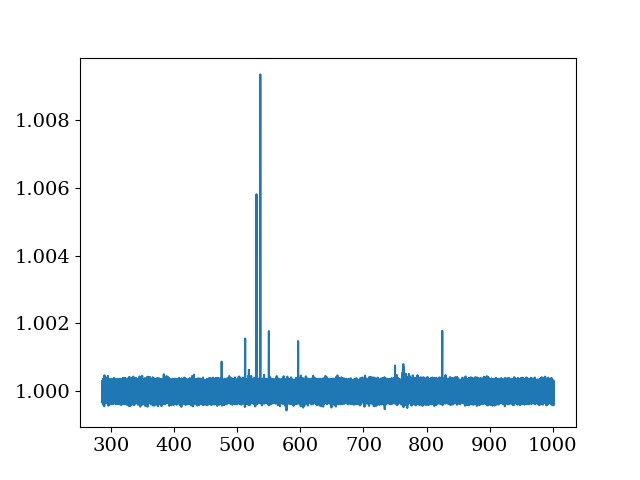

In [ ]:
plt.close('all')
plt.figure()
startIdx = int(1e6)
stopIdx = int(3.5e6)

plt.plot(freqs[startIdx:stopIdx], normSpec[startIdx:stopIdx])    

print(scipy.stats.median_abs_deviation(normSpec[startIdx:stopIdx]) * 1.4826)

In [ ]:
def consolidateCandidates(rawCanList, freqs, stepsize=1):
    '''
    Takes array of indices of candidates and returns a data frame
    with one row per candidate and columns with the candidate frequency,
    number of bins wide and the starting index of that candidate
    Inputs:
        rawCanList (1D list or np array): list of indices of candidates
        reqs (1D list or np array): list of frequencies
        stepsize: should be 1 to find adjecent candidates
    Calls:
        idx2Freq()
    '''
    rawCanList = np.asarray(rawCanList)
    splitList =  np.split(rawCanList, np.where(np.diff(rawCanList) > stepsize)[0]+1)
    canList = [can[0] for can in splitList] #list of inxs of first bin per candidate
    #print(matchedFreqs[np.asarray(canList)])
    #canListFreq = [matchedFreqs[can[0]] for can in splitList]
    #print(len(splitList))
    for can in splitList: #this is a total hack. It doesn't acount for the overlap in mach filter
        #this whole function is broken, but it will print candidates at least
        #print(can[0])
        print(np.arange(295, 1005, 286e-6)[can[0]])


    #canListFreq =  [idx2freq(can[0],freqs) for can in splitList]
    
    canLenList = [len(can) for can in splitList]
    candidate_df = pd.DataFrame()
    candidate_df['canFreq_Mhz'] = [freq/1e6 for freq in canListFreq]
    candidate_df['numBins'] = canLenList
    candidate_df['idx'] = canList
    #candidate_df['idx absolute'] = [idx + idxStart for idx in canList]
    diffArr = np.zeros(len(canList))
    diffArr[0] =  float('nan')
    diffArr[1:] = np.diff(canList)
    candidate_df['deltaIdx'] = diffArr
    candidate_df['deltaFreq_Hz'] = [deltaIdx* (s.SAMPLE_RATE) /s.CH0_RECORD_LEN for deltaIdx in diffArr]

    return candidate_df

stepsize = 10

antCanList_idx = ((matchedSpec>(matchedLim+1))) 
antCanIdx   = (np.where(antCanList_idx  == True))[0]
#print(antCanIdx)


candidate_df = consolidateCandidates(antCanIdx, matchedFreqs, stepsize=stepsize)
#candidate_df.to_csv(f'./candidateListCsvs/candidateList_run1_firstThird_diffGreaterThan10Bins_{nSigma}sigma_fc100bins_Order1_4_24_23.csv')
candidate_df

474.9763680106248
512.2313000128241
530.2247040138864
536.2221240142404
549.8963560150477
596.2011860177813
749.8721320268531
761.9161640275642
762.5934120276041
762.7304060276122
763.0126880276289
763.0610220276317
763.1022060276341
763.1522560276371
763.235768027642
763.2812420276448
763.5517980276607
763.5969860276634
763.6850740276686
765.7110980277882
824.791548031276


NameError: name 'canListFreq' is not defined

60


'\nplt.figure()\nplt.plot(freqs, spec[1:])\nplt.xlim(295,1005)\nplt.ylim(0.1e-10,0.215e-10)\n'

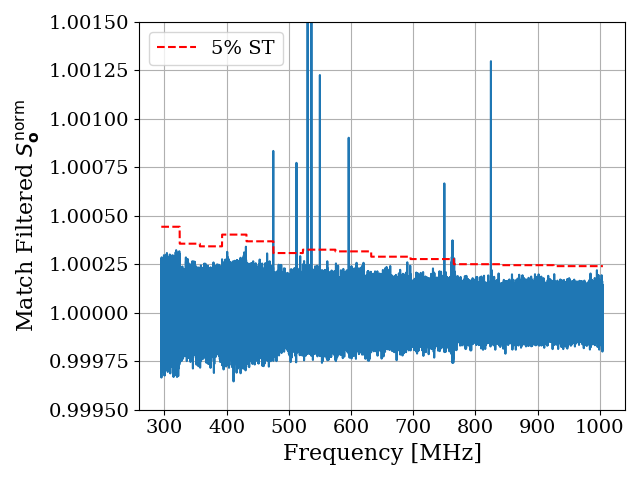

In [ ]:
print((matchedSpec>(matchedLim+1)).sum())

scale = 1
shift = 0
plt.close('all')
plt.plot(freqsMatched, (matchedSpec-shift)*scale)
plt.plot(freqsMatched, (matchedLim+1)*scale, 'r--', label = '5% ST')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'Match Filtered $S_\mathbf{o}^\mathrm{norm}$')
plt.ylim((0.9995-shift)*scale, (1.0015-shift)*scale)
#plt.hlines(1-shift, 295, 1005, 'k')
plt.tight_layout()
plt.grid()
plt.legend()
 
'''
plt.figure()
plt.plot(freqs, spec[1:])
plt.xlim(295,1005)
plt.ylim(0.1e-10,0.215e-10)
'''

In [ ]:
import matplotlib.pyplot as plt

# Sample data for demonstration
import numpy as np

# Import the necessary library for adding patches
import matplotlib.patches as patches

plt.close('all')
# Create linked x-axis plots with synchronized scrubbing capability
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot 1: freqsMatched with matchedSpec and matchedLim + 1
ax1.plot(freqsMatched, matchedSpec, zorder = -10)
ax1.plot(freqsMatched, matchedLim + 1, 'r--', label='5% ST')
ax1.set_ylabel(r'Match Filtered $S_\mathbf{o}^\mathrm{norm}$')
ax1.legend(loc = 'upper center')
ax1.grid(True)
ax1.set_ylim(0.9995, 1.0015)

# Add this inside your plot code, after plotting on ax2
box_x_start = 758  # start of the bump
box_x_end = 768    # end of the bump
box_y_bottom = 0.9996
box_y_top = 1.0005
# Add the rectangle patch around the bump near 760 MHz
rect = patches.Rectangle((box_x_start, box_y_bottom), box_x_end - box_x_start,
                         box_y_top - box_y_bottom, linewidth=3, edgecolor='red', facecolor='none', alpha = .5)
ax1.add_patch(rect)
ax1.text(650, 0.99955, '13 Candidates', fontsize = 16, color = 'r')


# Plot 2: freqs with avgVetoSpec
ax2.plot(freqs[:-10000], 10*np.log10(avgVetoSpec[1:-10000]), label='avgVetoSpec', zorder = -11)
ax2.set_ylabel('Veto Spectrum [dBm]')
#ax2.legend()
ax2.grid(True)
ax2.set_xlabel('Frequency [MHz]')
ax2.set_ylim(-162, -120)
ax2.set_xlim(470,850)
# Add this inside your plot code, after plotting on ax2
box_x_start = 758  # start of the bump
box_x_end = 768    # end of the bump
box_y_bottom = -160
box_y_top = -130
# Add the rectangle patch around the bump near 760 MHz
rect = patches.Rectangle((box_x_start, box_y_bottom), box_x_end - box_x_start,
                         box_y_top - box_y_bottom, linewidth=3, edgecolor='red', facecolor='none', alpha = .5)
ax2.add_patch(rect)
ax2.text(620, -161, 'FirstNet Allocation', fontsize = 16, color = 'r')

'''
# Plot 3: freqs with spec
ax3.plot(freqs[:-10000], spec[1:-10000], label='spec', color='green')
ax3.set_xlabel('Frequency (MHz)')
ax3.set_ylabel('spec')
ax3.legend()
ax3.grid(True)'''


# Add specific x-axis ticks on ax2 without labels
specific_freqs = [475.0415, 512.309, 530.309, 536.309,
                  549.9877, 596.309, 750.035, 824.982]
ax2.set_xticks(list(ax2.get_xticks()) + specific_freqs)  # Add specific frequencies to existing ticks
ax2.tick_params(axis='x', which='minor', length=5)  # Adjust tick length if necessary
ax2.set_xticklabels([f"{int(t)}" if t not in specific_freqs else "" for t in ax2.get_xticks()])


# Display the plots
plt.tight_layout()
plt.show()
